AI Programming - SW Lee

# Lab 07: Tabular Q Learning
## Exercise: Frozen Lake, Taxi

### Prepare Library Packages

In [2]:
# Check if this code runs in Colab
RunningInCOLAB = 'google.colab' in str(get_ipython()) # Colab에서 실행중인지 확인

if RunningInCOLAB: # Colab에서 실행중이라면
    !pip install gymnasium # gymnasium 설치
    from tqdm.notebook import tqdm # Colab에서는 tqdm.notebook을 사용
else:
    from tqdm import tqdm # 로컬 환경에서는 tqdm을 사용

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 16.1 MB/s eta 0:00:00


In [3]:
import numpy as np # numpy 라이브러리 임포트
import matplotlib.pyplot as plt # matplotlib 라이브러리 임포트
import gymnasium as gym # gymnasium 라이브러리 임포트
from gymnasium import wrappers # gymnasium.wrappers 라이브러리 임포트

In [4]:
gym.__version__ # gymnasium 버전 확인

'1.0.0'

### Select Environment

**Frozen Lake**<br>
https://gymnasium.farama.org/environments/toy_text/frozen_lake/


**Taxi**<br>
https://gymnasium.farama.org/environments/toy_text/taxi/

**Blackjack**<br>
https://gymnasium.farama.org/environments/toy_text/blackjack/

In [5]:
# select evironment
# Text Game:    0 for FrozenLake 4x4, 1 for Taxi, 2 for Blackjack

SELECT_ENV = 2 # 환경 선택

In [6]:
if SELECT_ENV == 0: # Frozen Lake
    env_name, res_prefix = 'FrozenLake-v1', 'lak4' # 환경 이름과 결과 파일명 설정
    max_episodes, max_ep_steps, goal_score = 3000, 500, 0.8 # 최대 에피소드 수, 최대 에피소드 단계 수, 목표 점수 설정
    val_ep_num, lr_rate, discount_rate = 20, 0.8, 0.95 # 검증 에피소드 수, 학습률, 할인율 설정
elif SELECT_ENV == 1: # Taxi
    env_name, res_prefix = 'Taxi-v3', 'taxi' # 환경 이름과 결과 파일명 설정
    max_episodes, max_ep_steps, goal_score = 1000, 500, 8.0 # 최대 에피소드 수, 최대 에피소드 단계 수, 목표 점수 설정
    val_ep_num, lr_rate, discount_rate = 20, 0.8, 0.95 # 검증 에피소드 수, 학습률, 할인율 설정
elif SELECT_ENV == 2: # Blackjack
    env_name, res_prefix = 'Blackjack-v1', 'blkj' # 환경 이름과 결과 파일명 설정
    max_episodes, max_ep_steps, goal_score = 5000, 10, -0.05 # 최대 에피소드 수, 최대 에피소드 단계 수, 목표 점수 설정
    val_ep_num, lr_rate, discount_rate = 1000, 0.1, 0.95 # 검증 에피소드 수, 학습률, 할인율 설정
else: assert False, 'environment selection error' # 환경 선택 오류

def create_env(): # 환경 생성 함수
    if   SELECT_ENV == 0: # Forzen Lake
        env = gym.make(env_name, desc=None, map_name='4x4', is_slippery=True, render_mode='rgb_array') # 환경 생성
    elif   SELECT_ENV == 1: # Taxi
        env = gym.make(env_name, render_mode='rgb_array') # 환경 생성
    elif   SELECT_ENV == 2: # Blackjack
        env = gym.make(env_name, natural=False, sab=False, render_mode='rgb_array') # 환경 생성
    else: pass # 환경 선택 오류
    return env # 환경 반환

In [7]:
def env_reset(env): # 환경 초기화 함수
    observation = env.reset() # 환경 초기화
    obs = observation[0] if type(observation)==tuple else observation # 관찰값 설정
    if SELECT_ENV == 2: # Blackjack
        state = obs[0] + 32 * obs[2] + 64 * obs[1] # 상태 설정
    else: state = obs # 상태 설정
    return state # 상태 반환

def env_step(env, action): # 환경 단계 함수
    observation = env.step(action) # 환경 단계
    if SELECT_ENV == 2: # Blackjack
        state = observation[0][0] + 32 * observation[0][2] + 64 * observation[0][1] # 상태 설정
    else: state = observation[0] # 상태 설정
    reward = observation[1] # 보상 설정
    done = observation[2] or observation[3] if len(observation)>4 else observation[2] # 종료 여부 설정
    return state, reward, done # 상태, 보상, 종료 여부 반환

In [8]:
env = create_env() # 환경 생성
state = env_reset(env) # 환경 초기화
state, reward, done = env_step(env, env.action_space.sample()) # 환경 단계

### Check and Show Environment Variables

In [9]:
action_shape = env.action_space.shape # 행동 공간 모양 설정
action_space_type = type(env.action_space) # 행동 공간 타입 설정

if action_space_type==gym.spaces.discrete.Discrete: # 행동 공간 타입이 이산형일 경우
    actn_space = 'DISCRETE' # 행동 공간 설정
    action_shape = (1,) # 행동 모양 설정
    action_dims = 1 # 행동 차원 설정
    action_range = env.action_space.n # 행동 범위 설정
    num_actions = action_range  # number of actions is action range for DISCRETE actions
    action_batch_shape = (None, action_range) # 행동 배치 모양 설정
elif action_space_type==gym.spaces.box.Box: # 행동 공간 타입이 상자형일 경우
    actn_space = 'CONTINUOUS' # 행동 공간 설정
    action_dims = action_shape[0] # 행동 차원 설정
    actn_uppr_bound = env.action_space.high[0] # 행동 상한 설정
    actn_lowr_bound = env.action_space.low[0] # 행동 하한 설정
    action_range = (actn_uppr_bound - actn_lowr_bound) # x0.5 for tanh output
    action_batch_shape = tuple([None]+[x for x in action_shape]) # 행동 배치 모양 설정
    num_actions = action_dims   # number of actions is action dimension for CONTINUOUS actions
else: assert False, 'other action space type are not supported'

observation_space_type = type(env.observation_space) # 관찰 공간 타입 설정
observation_shape = env.observation_space.shape # 관찰 공간 모양 설정

if observation_space_type==gym.spaces.discrete.Discrete: # 관찰 공간 타입이 이산형일 경우
    observation_shape = (1,) # 관찰 공간 모양 설정
    num_states = env.observation_space.n # 상태 수 설정
elif observation_space_type==gym.spaces.box.Box: # 관찰 공간 타입이 상자형일 경우
    num_states = observation_shape[0] # 상태 수 설정
elif observation_space_type==gym.spaces.tuple.Tuple: # 관찰 공간 타입이 튜플형일 경우
    observation_shape = tuple([x.n for x in env.observation_space]) # 관찰 공간 모양 설정
    num_states = np.prod(observation_shape) # 상태 수 설정
else: print('observation space type error') # 관찰 공간 타입 오류

if SELECT_ENV == 2: # Blackjack
    state_shape = (1,) # 상태 모양 설정
    state_batch_shape = (None,1) # 상태 배치 모양 설정
else:
    state_shape = observation_shape # 상태 모양 설정
    state_batch_shape = tuple([None]+[x for x in observation_shape]) # 상태 배치 모양 설정

value_shape = (1,) # 가치 모양 설정
num_values = 1 # 가치 수 설정

In [10]:
print('Action space ', action_space_type) # 행동 공간 출력
print('Action shape ', action_shape) # 행동 모양 출력
print('Action dimensions ', action_dims) # 행동 차원 출력
print('Action range ', action_range) # 행동 범위 출력
if action_space_type==gym.spaces.box.Box: # 행동 공간 타입이 상자형일 경우
    print('Max Value of Action ', actn_uppr_bound) # 행동 상한 출력
    print('Min Value of Action ', actn_lowr_bound) # 행동 하한 출력
else: pass # 그 외의 경우
print('Action batch shape ', action_batch_shape) # 행동 배치 모양 출력

print('Observation space ', observation_space_type) # 관찰 공간 출력
print('Observation shape ', observation_shape) # 관찰 공간 모양 출력
print('Size of State Space ', num_states) # 상태 공간 크기 출력
print('State shape ', state_shape) # 상태 모양 출력
print('State batch shape ', state_batch_shape) # 상태 배치 모양 출력

print('Vallue shape ', value_shape) # 가치 모양 출력
print('Value dimensions ', num_values) # 가치 차원 출력

Action space  <class 'gymnasium.spaces.discrete.Discrete'>
Action shape  (1,)
Action dimensions  1
Action range  2
Action batch shape  (None, 2)
Observation space  <class 'gymnasium.spaces.tuple.Tuple'>
Observation shape  (32, 11, 2)
Size of State Space  704
State shape  (1,)
State batch shape  (None, 1)
Vallue shape  (1,)
Value dimensions  1


### Define and Initialize The Agent
### **Exercise:** Define Q-table (Numpy)

In [11]:
### START CODE HERE ###

Q_table = np.zeros((num_states, action_range))  # define q-table

###  END CODE HERE  ###

print(Q_table.shape) # Q 테이블 모양 출력

(704, 2)


### Define and Initialize Hyperparameters

In [12]:
total_episodes = max_episodes   # Total episodes
max_steps = max_ep_steps        # Max steps per episode
learning_rate = lr_rate         # Learning rate
gamma = discount_rate           # Discounting rate
val_episodes = val_ep_num       # number of validation episodes


### Define Epsilon Function

This is an example of exponential decay epsilon function. One of easist epsilon decay functions is simply to multiply 0.9. You can define your own epsilon function.

In [13]:
# Exploration parameters for epsilon greedy strategy
class Epsilon: # 엡실론 클래스
    def __init__(self, max_steps):          # initialize epsilon
        self.explore_start = 1.0            # exploration probability at start
        self.explore_stop = 0.01            # minimum exploration probability
        self.decay_rate = 20.0/max_steps    # exponential decay rate for exploration prob (4.6 ~ max_step = 0.01)
        self.steps = 0

    def get_epsilon(self): # 엡실론 반환 함수
        eps = (self.explore_stop # calculate new epsilon
            + (self.explore_start - self.explore_stop) * np.exp(-self.decay_rate * self.steps)) # 새 엡실론 계산
        self.steps += 1 # 엡실론 증가
        return eps # 엡실론 반환

### Learning Procedures

Q-learning is an off-policy TD control algorithm.

$$ Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha (r_{t} + \gamma \max_{a} Q(s_{t+1},a) - Q(s_t,a_t) ) $$

The target policy $\pi$ is greedy w.r.t. $Q(s,a)$

$$ \pi (s_{t}) = \arg \max_{a^\prime} Q(s_{t},a^\prime) $$

### **Exercise:** Define Training Loop and Evaluation Loop

In [14]:
def evaluate_policy(env, qtable, num_average, images=None): # 정책 평가 함수

    total_reward = 0.0 # 총 보상 초기화
    total_steps = 0  # 총 단계 초기화
    episodes_to_play = num_average # 평균을 내기 위한 에피소드 수
    for _ in range(episodes_to_play):                   # Play n episode and take the average
        state = env_reset(env) # reset the environment
        if images!=None: images.append(env.render()) # 환경 렌더링
        done = False # 종료 여부 초기화
        episode_reward = 0.0 # 에피소드 보상 초기화
        while not done: # 종료되지 않을 때까지

            ### START CODE HERE ###

            action = np.argmax(qtable[state, :])            # get an action from q-table
            next_state, reward, done = env_step(env, action)  # take action and observe outcomes

            ###  END CODE HERE  ###

            if images!=None: images.append(env.render()) # 환경 렌더링
            state = next_state                          # update state
            episode_reward += reward # 에피소드 보상 증가
            total_steps += 1 # 총 단계 증가
        total_reward += episode_reward # 총 보상 증가
    average_reward = total_reward / episodes_to_play    # take the average reward of evaluations
    average_steps = total_steps / episodes_to_play      # take the average steps of evaluations

    return average_reward, average_steps, images # 평균 보상, 평균 단계, 이미지 반환


In [15]:
history = {'rewards' : []}                          # logs of rewards
epsF = Epsilon(total_episodes)                      # generate epsilon object

pbar = tqdm(range(total_episodes), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}') # 프로그레스 바 설정

for episodes in pbar: # 에피소드 반복

    # initialize variables for a new episode
    epis_rewards = 0                                # episode reward
    epis_steps = 0                                  # steps for an episode
    done = False                                    # episode end flag

    state = env_reset(env)                          # Reset the environment

    epsilon = epsF.get_epsilon()                    # get new epsilon value

    while not done:                                 # simulate to the terminal state of the episode

        ### START CODE HERE ###

        explore_probability = np.random.uniform(0, 1)    # get a random number for exploration decision
        if explore_probability > epsilon:
            action = np.argmax(Q_table[state, :])        # exploitation: choose the action with max Q-value
        else:
            action = np.random.randint(0, action_range)  # exploration: choose a random action

        next_state, reward, done = env_step(env, action)  # take the action to environment and observe outcomes

        # Q-learning update
        td_target = reward + gamma * np.max(Q_table[next_state, :]) # 계산된 TD 타겟
        Q_table[state, action] += learning_rate * (td_target - Q_table[state, action]) # Q 테이블 업데이트

        ### END CODE HERE ###

        epis_rewards += reward                      # accumulate rewards to calculate the episode reward
        state = next_state                          # set state for the next state

        if epis_steps > max_steps: break            # if run too much : finish episode
        else: epis_steps += 1

    # evaluate the policy
    eval_reward, eval_steps, _ = evaluate_policy(env, Q_table, val_episodes) # evaluate the policy

    history['rewards'].append(eval_reward) # 보상 기록

    pbar.set_postfix({'reward':eval_reward, 'steps':eval_steps}) # 프로그레스 바 업데이트

    if eval_reward>goal_score: break                # exit if convergence

print('episodes:{0:5d}, final_reward {1:4.2f}'.format(episodes, eval_reward)) # 최종 보상 출력

  0%|          | 0/5000 [00:00<?, ?it/s]

episodes:  446, final_reward -0.04


### Plot Training Histories

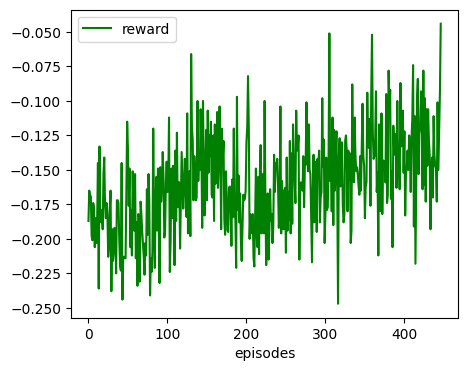

In [16]:
# plot loss and accuracy
def plot_graphs(log_history, log_labels, graph_labels, graph_colors=['b-','g-']): # 그래프 플로팅 함수
    num_graphs = len(log_labels) # 그래프 수
    plt.figure(figsize=(5*num_graphs,4)) # 그래프 크기 설정
    for i in range(num_graphs): # 그래프 반복
        plt.subplot(1,num_graphs,i+1) # 서브플롯 설정
        plt.plot(log_history[log_labels[i]], graph_colors[i], label=graph_labels[i]) # 그래프 플로팅
        plt.xlabel('episodes') # x축 레이블 설정
        plt.legend() # 범례 설정
    plt.show() # 그래프
    return

log_labels    = ['rewards'] # 로그 레이블 설정
label_strings = ['reward'] # 레이블 문자열 설정
label_colors  = ['g-'] # 레이블 색상 설정
plot_graphs(history, log_labels, label_strings, label_colors) # 그래프 플로팅

### Evaluate the Agent

Evaluate the agent here to show the performance

In [17]:
evaluate_episodes = 20 # 평가 에피소드 수
sum_episode_rewards = 0.0 # 총 에피소드 보상 초기화
pbar = tqdm(range(evaluate_episodes)) # 프로그레스 바 설정

for i in pbar: # 반복
    rewards, _, _ = evaluate_policy(env, Q_table, 1) # 정책 평가
    sum_episode_rewards += rewards # 총 에피소드 보상 증가

env.close() # 환경 종료

print('Evaluation Result:',  sum_episode_rewards/evaluate_episodes) # 평가 결과 출력

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation Result: -0.5


## See How The Agent Works

In [32]:
env = create_env() # 환경 생성

if SELECT_ENV != 2: # Blackjack
    env = wrappers.RecordVideo(env, video_folder='./gym-results/', name_prefix=res_prefix) # 비디오 레코딩 설정
    eval_reward, _, _ = evaluate_policy(env, Q_table, 1) # 정책 평가
else:
    ims = [] # 이미지 초기화
    eval_reward, _, ims = evaluate_policy(env, Q_table, 1, ims) # 정책 평가

print('Sample Total Reward:', eval_reward) # 샘플 총 보상 출력

env.close() # 환경 종료

Sample Total Reward: 1.0


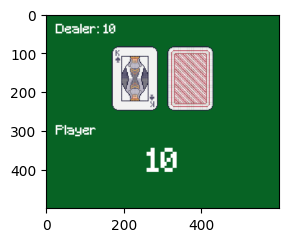

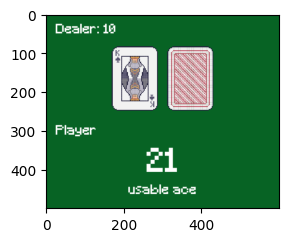

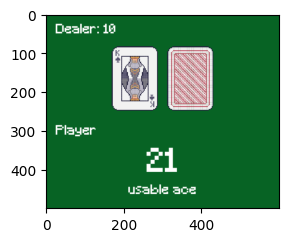

In [33]:
from IPython.display import HTML, display # HTML, display 라이브러리 임포트
from base64 import b64encode # b64encode 라이브러리 임포트

def show_video(video_path, video_width = 320): # 비디오 표시 함수
    video_file = open(video_path, "r+b").read() # 비디오 파일 읽기
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}" # 비디오 URL 설정
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""") # 비디오 출력

if SELECT_ENV==2: # Blackjack
    for i in range(len(ims)): # 이미지 반복
        plt.figure(figsize=(3,3)) # 그림 크기 설정
        plt.imshow(ims[i]) # 이미지 출력
        plt.show() # 그림 출력
else:
    display(show_video('./gym-results/' + res_prefix + '-episode-0.mp4')) # 비디오 표시

(c) 2024 SW Lee